# Set Up / Test On One Image

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [2]:
from google.colab import drive

drive.mount('/content/gdrive/')
path = 'gdrive/MyDrive/procodes/'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
from imageio import volread as imread
# we import an image stack of 28 images
# each image represents a different marker 
img = imread(path+'F000_max.tif')
img = img.astype(np.float32) / img.max((1,2),keepdims=True) # equalize channels, so it better matches our assumptions on codebook
img.shape

(28, 2048, 2048)

In [4]:
markers = pd.read_csv(path+'markers.csv')
print(markers.shape)
markers.head()

(28, 9)


,channel_number,cycle_number,marker_name,Filter,excitation_wavelength,emission_wavelength,Bandwidth,ch_index,Split_Num
0,1,0,DNA_0,DAPI,405,445,46,0,0
1,2,0,Blank_488_0,GFP,488,521,38,1,1
2,3,0,Blank_561_0,RFP,561,594,43,2,2
3,4,0,Blank_637_0,Cy5,637,698,77,3,3
4,5,1,DNA_1,DAPI,405,445,46,0,4


(19, 7)

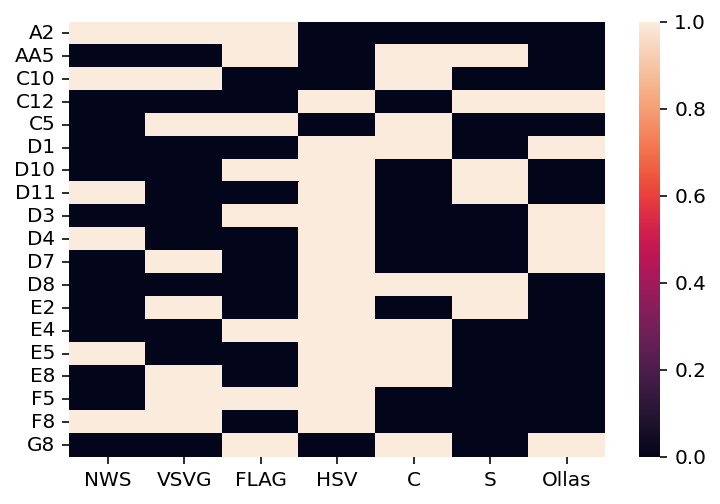

In [5]:
codebook = pd.read_csv(path+'codebook.csv',sep='.',index_col=0)
# Y AXIS is marker names, and X AXIS is 
sns.heatmap(codebook.T)
codebook.T.shape

In [6]:
markers_vals = list(markers['marker_name'][markers['marker_name'].isin(codebook.index)])

In [7]:
# run this once
img = img[markers['marker_name'].isin(codebook.index)]
img.shape

(7, 2048, 2048)

In [8]:
A = codebook.values.copy().T
A

array([[1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 1., 0.],
       [1., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 1., 1.],
       [0., 1., 1., 0., 1., 0., 0.],
       [0., 0., 0., 1., 1., 0., 1.],
       [0., 0., 1., 1., 0., 1., 0.],
       [1., 0., 0., 1., 0., 1., 0.],
       [0., 0., 1., 1., 0., 0., 1.],
       [1., 0., 0., 1., 0., 0., 1.],
       [0., 1., 0., 1., 0., 0., 1.],
       [0., 0., 0., 1., 1., 1., 0.],
       [0., 1., 0., 1., 0., 1., 0.],
       [0., 0., 1., 1., 1., 0., 0.],
       [1., 0., 0., 1., 1., 0., 0.],
       [0., 1., 0., 1., 1., 0., 0.],
       [0., 1., 1., 1., 0., 0., 0.],
       [1., 1., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 1.]])

In [9]:
from skimage.filters import threshold_otsu, rank
from skimage.morphology import disk

# this needs tweaking, is slow
# cellprofiler "enhance neurites" might be good here
def local_otsu(img, radius):
    selem = disk(radius)
    threshold = rank.otsu(img, selem)
    return threshold

A = codebook.values.copy().T
x = img.copy()
max_iters = 2
nonneg = True

# approximately solve min_z ||zA-x||^2_2 st ||z||_0 <= max_iters
def matching_pursuit(x, A, max_iters, thr=1):
    # this is necessary if doing more than one iteration, for the residuals update to work
    A = A / np.linalg.norm(A,axis=1)[:,None]
    print(A)
    z = np.zeros((A.shape[0],*x.shape[1:]))

    x = x.copy() # initialize "residuals" to the image itself

    # mask for whether each pixel has converged or not; we already know background's zero
    active_set = np.ones(x.shape[1:],dtype=bool)
    x_norm = np.linalg.norm(x,axis=0,ord=2)

    # pick it using the otsu threshold, as estimate of noise level
    max_norm = threshold_otsu(x_norm)
    max_norm *= thr # hack; otsu just not great. see 'enhance neurites' in CellProfiler?
    active_set[x_norm < max_norm] = False

    for t in range(max_iters):
        # project dictionary on residual image
        Ax = A @ x[:,active_set]
        # pick index with max projection
        k_max = Ax.argmax(0)
        # set it to active
        z[k_max,active_set] = Ax[k_max,range(len(k_max))]
        # subtract off contribution
        x[:,active_set] -= A[k_max].T * z[k_max,active_set]
        # mark pixels with sufficiently small residual norm as done
        x_norm = np.linalg.norm(x,axis=0,ord=2)
        active_set[x_norm<max_norm] &= False
        
    return z

A = codebook.values.copy().T
print(A)
x = img.copy()
max_components = 3
fudge_factor = 0.8
z = matching_pursuit(x, A, max_components, fudge_factor)

[[1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 1. 0.]
 [1. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 1. 1.]
 [0. 1. 1. 0. 1. 0. 0.]
 [0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 1. 1. 0. 1. 0.]
 [1. 0. 0. 1. 0. 1. 0.]
 [0. 0. 1. 1. 0. 0. 1.]
 [1. 0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 1. 0. 0. 1.]
 [0. 0. 0. 1. 1. 1. 0.]
 [0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [1. 0. 0. 1. 1. 0. 0.]
 [0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1.]]
[[0.57735027 0.57735027 0.57735027 0.         0.         0.
  0.        ]
 [0.         0.         0.57735027 0.         0.57735027 0.57735027
  0.        ]
 [0.57735027 0.57735027 0.         0.         0.57735027 0.
  0.        ]
 [0.         0.         0.         0.57735027 0.         0.57735027
  0.57735027]
 [0.         0.57735027 0.57735027 0.         0.57735027 0.
  0.        ]
 [0.         0.         0.         0.57735027 0.57735027 0.
  0.57735027]
 [0.         0.         0.57735027 0.57735027 0.         0.57735027
  0.        ]
 

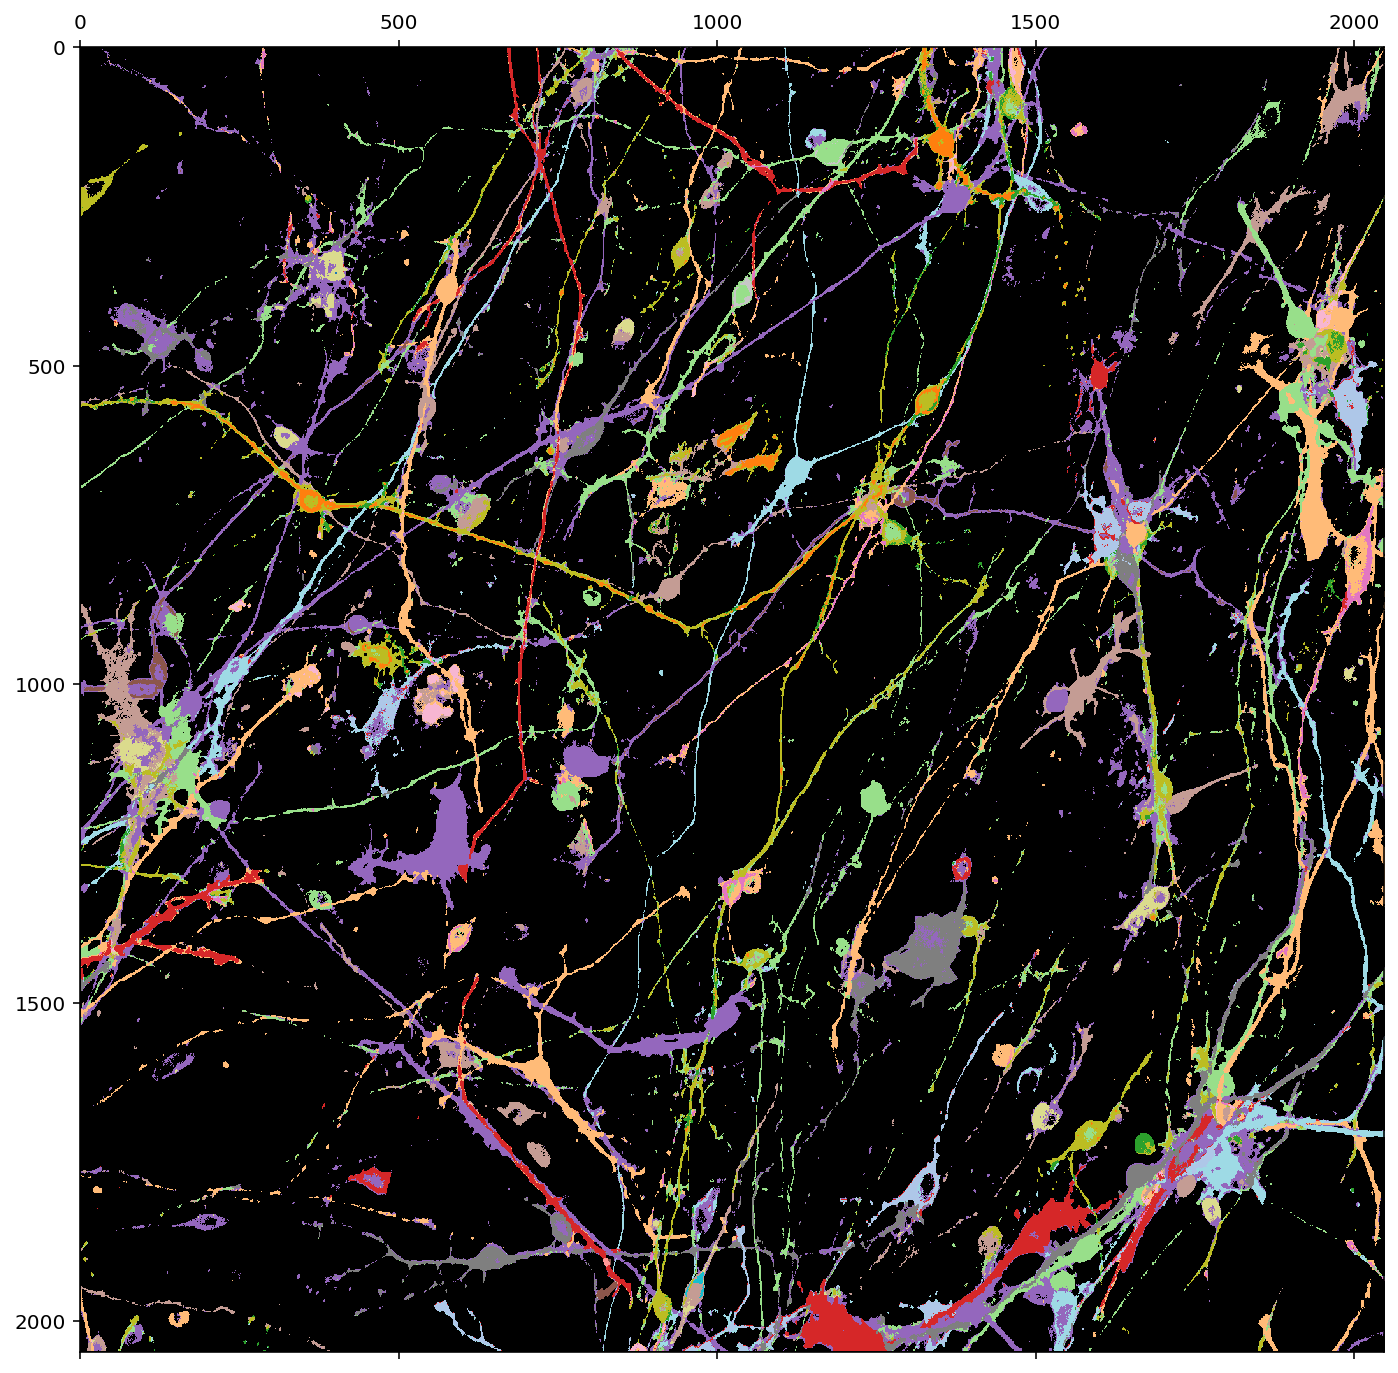

In [10]:
cm = plt.get_cmap('tab20')
cm.set_bad('k')
plt.figure(figsize=(12,12))
plt.gca().matshow(np.where(z.max(0)==0,np.nan,z.argmax(0)),cmap=cm)

$y \in \mathbb{R}^{D\times W \times H}, A \in \mathbb{R}^{D\times K}, f \in \mathbb{R}^{D\times W \times H} \rightarrow \mathbb{R}^{K\times W \times H}$

$\min_{f} \Vert y - A f(y) \Vert_2^2$

This is the "teacher" model. Idea is to solve the deconvolution problem, with implicit spatial regularization via parametrizing $f$ as a convolutional neural network. In general solutions to this probably won't be sparse, but that may not be a huge deal.

$\min_{g} \Vert \nabla^2_{wh} f(y) - g(\sum_{k} y^{k}) \Vert$

The "student" then tries to predict the magnitude of edges (i.e. the Frobenius norm of the Jacobian wrt spatial coordinates) in the teacher's output from the *grayscale* image.

In [11]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline


# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [12]:
images = ['F000_max.tif', 'F001_max.tif', 'F002_max.tif', 'F003_max.tif']
train_x_data = []
train_y_data = []
for i in tqdm(images):
    img = imread(path+i)
    img = img.astype(np.float32) / img.max((1,2),keepdims=True) # equalize channels, so it better matches our assumptions on codebook
    img = img[markers['marker_name'].isin(codebook.index)]
    for channel in range(len(img)):
        train_x_data.append(img[channel])
        train_y_data.append(channel)

val_data_x = train_x_data[0:7]
val_data_y = train_y_data[0:7]

100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f862b4626d0>,
 <matplotlib.image.AxesImage at 0x7f862b3dda90>)

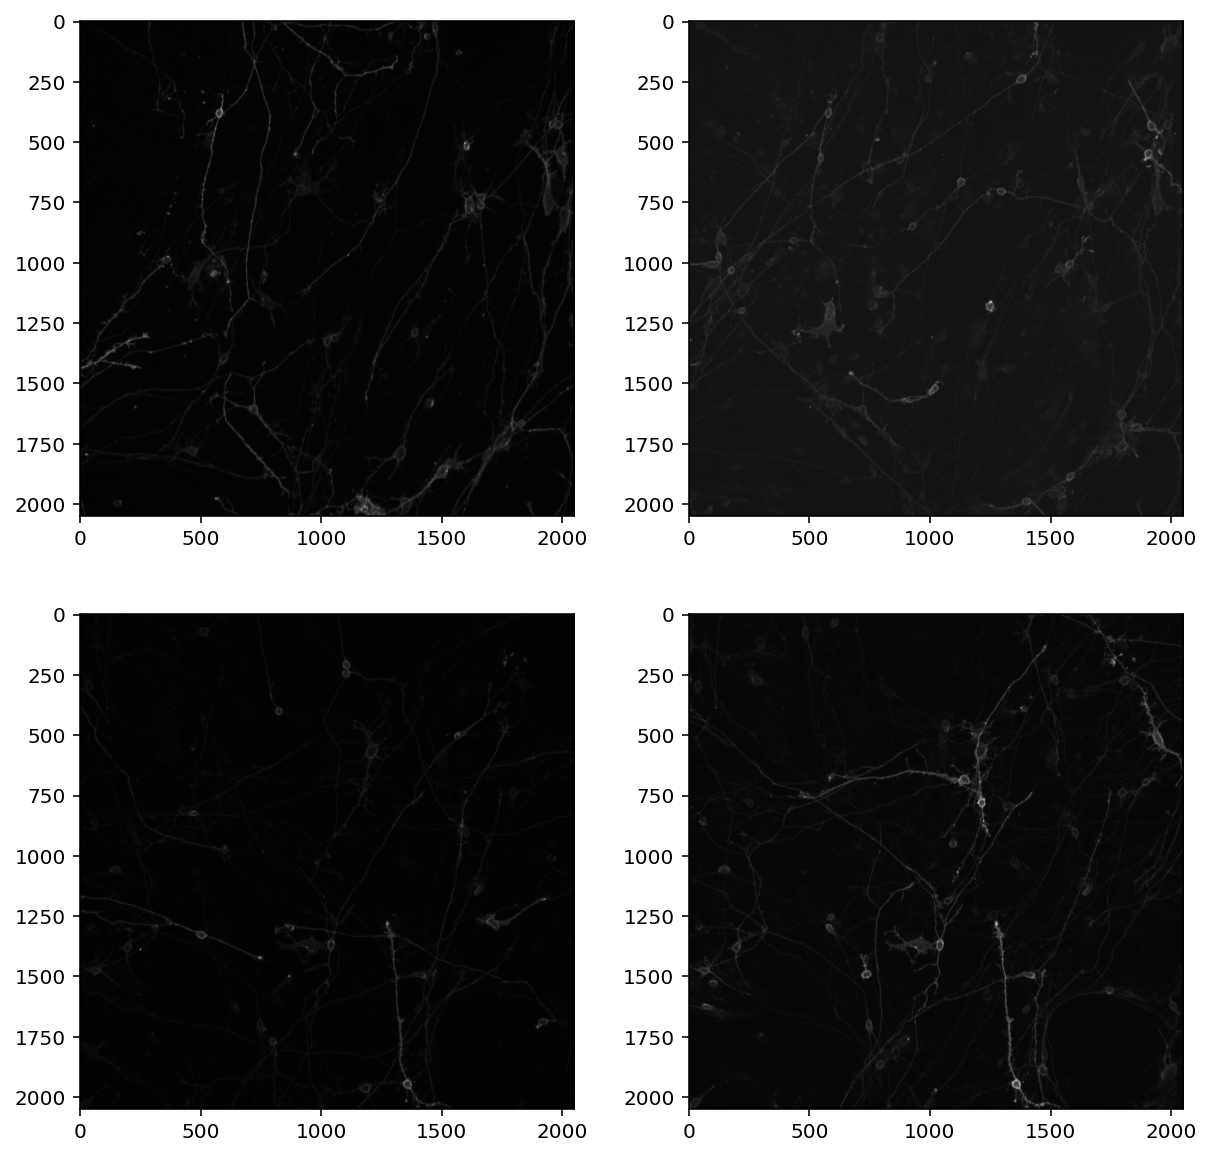

In [13]:
i = 5
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_x_data[i], cmap='gray')
plt.subplot(222), plt.imshow(train_x_data[i+1], cmap='gray')
plt.subplot(223), plt.imshow(train_x_data[i+2], cmap='gray')
plt.subplot(224), plt.imshow(train_x_data[i+3], cmap='gray')


In [14]:
train_x = torch.tensor(train_x_data)
train_y = torch.tensor(train_y_data)
val_x = torch.tensor(val_data_x)
val_y = torch.tensor(val_data_y)
train_x.shape, val_y.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  """Entry point for launching an IPython kernel.


(torch.Size([28, 2048, 2048]), torch.Size([7]))

In [15]:
val_x.shape

torch.Size([7, 2048, 2048])

In [16]:
train_x = train_x.reshape(28, 1, 2048, 2048)
val_x = val_x.reshape(7, 1, 2048, 2048)
train_x.shape, val_x.shape

(torch.Size([28, 1, 2048, 2048]), torch.Size([7, 1, 2048, 2048]))

In [17]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()
        self.batch_size = 8
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 2, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(2),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),

            # Defining another 2D convolution layer
            Conv2d(2, 2, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(2),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(524288, 7)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [18]:
# define the model
model = Net()
# define optimizer
optimizer = Adam(model.parameters(), lr=0.001)
# define loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    print('Cuda is available')
print(model)

Cuda is available
Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=524288, out_features=7, bias=True)
  )
)


In [19]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [20]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 11.4 GB  |     Proc size: 4.2 GB
GPU RAM Free: 10941MB | Used: 500MB | Util   4% | Total     11441MB


In [21]:
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : tensor(2.0771, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  3 	 loss : tensor(15.8824, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  5 	 loss : tensor(8.6264, device='cuda:0', grad_fn=<NllLossBackward0>)


RuntimeError: ignored